# Watermass transformation analysis

**Visualization notebook**

This notebook visualizes the output of the `wmtr` watermass analysis code. The code was processed on a series of monthly POP model results files with the configuration `bc5_ne120_t12_v0.1`.

***

In [36]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, patches

In [2]:
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

## Data, variables and processing

There are 14 regional masks that are considered in the `wmtr` code, shown in the figure below.

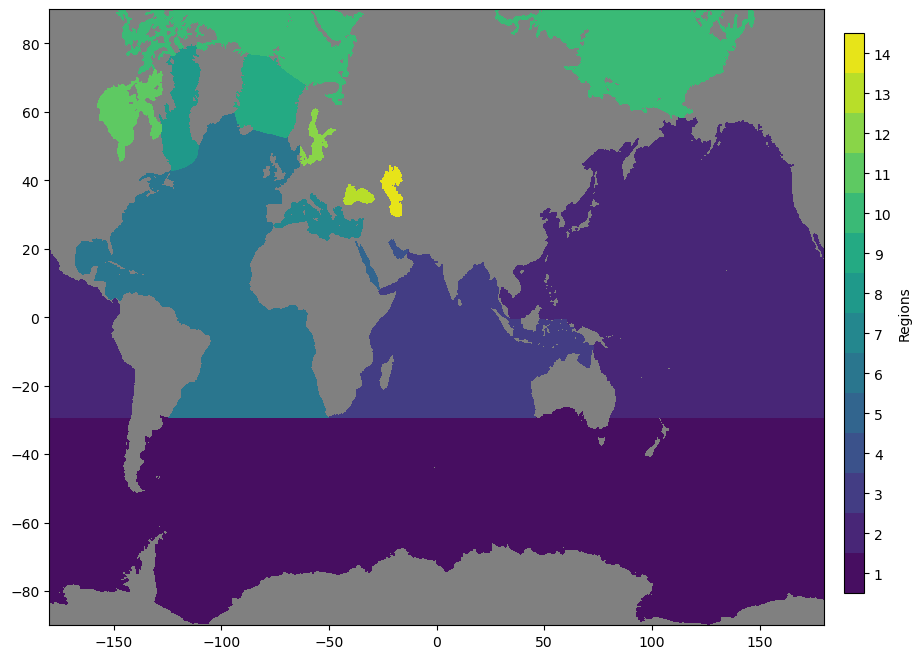

In [53]:
# Load region mask
resultspath = '/pscratch/sd/b/bmoorema/results/bc5_ne120_t12_v0.1/'
filename = f'bc5_ne120_t12_v0.1_00002.pop.h.1996-01.nc'
with xr.open_dataset(resultspath + filename) as ds:
    regionmask = ds.REGION_MASK.values.astype(int)
regionmask = abs(np.ma.masked_where((regionmask == 0) | (regionmask == -1), regionmask))

# Plot regions
fig, ax = plt.subplots(figsize=(10, 8))
lon, lat = np.linspace(-180, 180, 3600), np.linspace(-90, 90, 2400)
ax.add_patch(patches.Rectangle((0, 0), 1, 1, fc='gray', transform=ax.transAxes))
c = ax.contourf(lon, lat, regionmask, levels=range(0, 15))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(c, cax=cax, label='Regions', ticks=np.arange(0.5, 14.5))
cbar.set_ticklabels(range(1, 15))

To the best of my sleuthing, these regions correspond to the array indices defined below.

In [4]:
# Define regions
regiondict = {
    0:  'Southern Ocean',
    1:  'Pacific Ocean',
    2:  'Indian Ocean',
    3:  'Persian Gulf',
    4:  'Red Sea',
    5:  'Atlantic Ocean',
    6:  'Mediterranean Sea',
    7:  'Labrador Sea',
    8:  'Greenland Sea',
    9:  'Arctic Ocean',
    10: 'Hudson Bay',
    11: 'Baltic Sea',
    12: 'Black Sea',
    13: 'Caspian Sea',
    14: 'Total',
}

# Reference watermasses (Howe and Czaja, 2009)
watermasses = {
    'STMW': {'sigma': [26.2, 27], 'fc': 'bisque'},     # Subtopical mode water (18 deg)
    'SPMW': {'sigma': [27.3, 29], 'fc': 'lavender'},      # Subpolar mode water + Labrador sea water
    'SAMW': {'sigma': [26.5, 27], 'fc': 'powderblue'},    # Subantarctic mode water
}

# Density index
sigma_index = np.arange(19, 29.01, 0.1)

# Results path
resultspath = '/pscratch/sd/b/bmoorema/results/wmfr_output/bc5_ne120_t12_v0.1_00002/TR/'

Load and parse Fortran binary outputs

In [5]:
# Load and processes data from Fortran binary outputs
wmtrfr = {}
for hs in ['nh', 'sh']:

    # Load data from Fortran binary (double precision, big endian)
    # Use numpy.fromfile, for some reason scipy.io.FortranFile doesn't play nice here
    data = np.fromfile(resultspath + f'transfrm_{hs}_ann_2000.dat', dtype='>f8')
    
    # Convert to float64, reshape to [record, regions, variables] and parse variables to dict
    data = list(data.astype('float64').reshape([101, 15, 5], order='F').T)
    variables = ['area', 'heat', 'salt', 'heat_ice', 'salt_ice']
    wmtrfr[hs] = {'tr': {var: values for var, values in zip(variables, data)}, 'fr': {}}
    
    # Convert to Sv (or km2 for area)
    for var in wmtrfr[hs]['tr']:
        wmtrfr[hs]['tr'][var] = wmtrfr[hs]['tr'][var] * 1e-6
    
    # Calculate totals
    wmtrfr[hs]['tr']['total'] = wmtrfr[hs]['tr']['heat'] + wmtrfr[hs]['tr']['salt']
    wmtrfr[hs]['tr']['total_ice'] = wmtrfr[hs]['tr']['heat_ice'] + wmtrfr[hs]['tr']['salt_ice']
    wmtrfr[hs]['tr']['total_noice'] = wmtrfr[hs]['tr']['total'] - wmtrfr[hs]['tr']['total_ice']
    
    # Calculate watermass formation
    for var in wmtrfr[hs]['tr']:
        wmtrfr[hs]['fr'][var] = -np.diff(wmtrfr[hs]['tr'][var], append=0)

Plot generating function

In [17]:
def make_plots(regions=[0], hemisphere='sh', xlim=[19, 29], plot_total=True):
    """
    """

    if hemisphere == 'nh':
        wms = ['STMW', 'SPMW']
    else:
        wms = ['SAMW']
    
    # Make figure layout
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    
    # Panel matrix lists
    qtys, titles = ['tr', 'fr'], ['Transformation', 'Formation']
    variables, labels = ['total', 'heat', 'salt'], ['Buoyancy ', 'Thermal ', 'Haline ']

    # sigma indices within xlim
    xindex = (sigma_index > xlim[0]) & (sigma_index < xlim[1])
    
    # Loop through columns
    for col, qty, title in zip(axs.T, qtys, titles):

        # Find ylim
        values = []
        for region in regions:
            for var in variables:
                values.append(wmtrfr[hemisphere][qty][var][region, xindex])
        values = np.hstack(values)
        ylim = [values.min(), values.max()]
    
        # Labels
        col[0].set_title(title)
        col[1].set_ylabel('Sv')
        col[2].set_xlabel('$\\sigma_{\\theta}$')
    
        # Loop through rows
        for ax, var, label in zip(col, variables, labels):
    
            # Plot tr and fr curves
            for region in regions:
                ax.plot(sigma_index, wmtrfr[hemisphere][qty][var][region, :], '-', label=regiondict[region], zorder=3)
            if plot_total:
                ax.plot(sigma_index, wmtrfr[hemisphere][qty][var][14, :], '-', color='lightgray', label='total', zorder=2)
    
            # Plot watermasses
            for wm in wms:
                sigmas = [(sigma, sigma) for sigma in watermasses[wm]['sigma']]
                ax.fill_betweenx(ylim, *sigmas, fc=watermasses[wm]['fc'], zorder=0)
                if (qty == 'fr') & (var == 'salt'):
                    ax.text(sigmas[0][0], ylim[1], wm)
    
            # Formatting
            ax.plot([19, 29], [0, 0], 'k--', zorder=1)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
    
            # Panel-specific formatting
            if var != 'salt':
                ax.xaxis.set_ticklabels('')
            if qty == 'tr':
                ax.text(0.01, 0.03, label, transform=ax.transAxes)

    axs[2, 1].legend()

    return fig, axs

***

## Plots

#### Southern Hemisphere

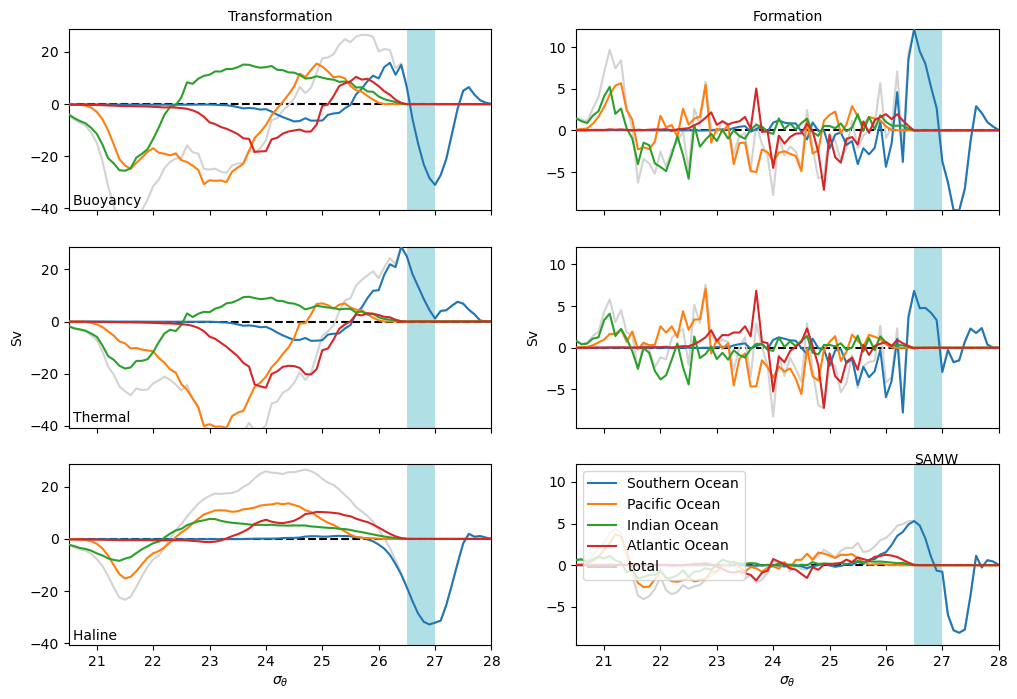

In [18]:
# Southern Hemisphere
fig, axs = make_plots(regions=[0, 1, 2, 5], hemisphere='sh', xlim=[20.5, 28], plot_total=True)

#### Northern hemisphere

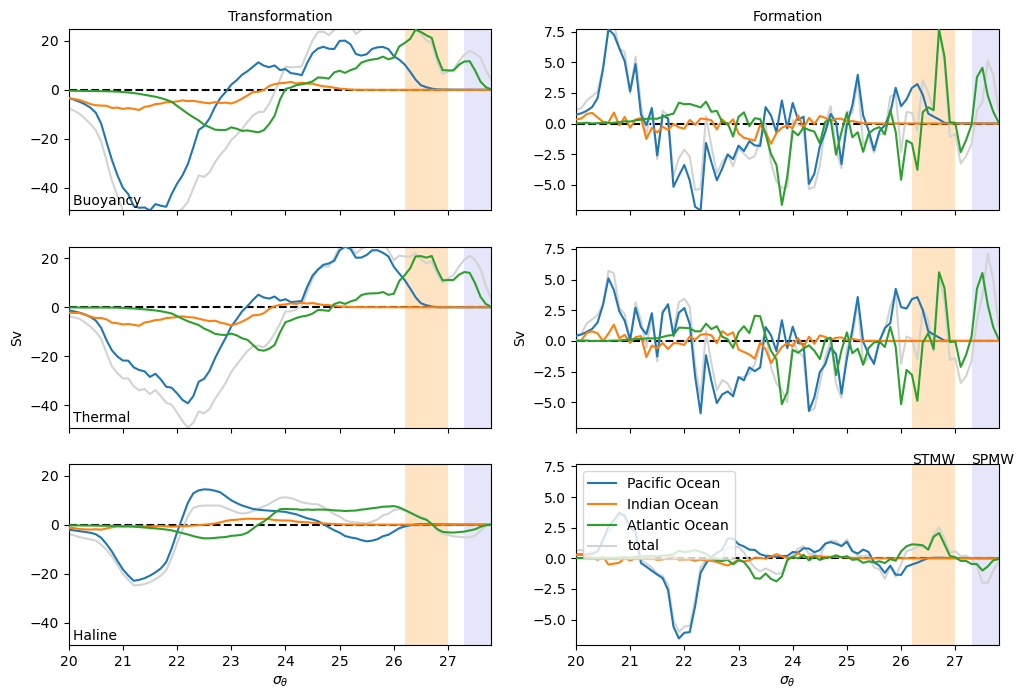

In [19]:
# Northern Hemisphere
fig, axs = make_plots(regions=[1, 2, 5], hemisphere='nh', xlim=[20, 27.8], plot_total=True)

#### High Latitude

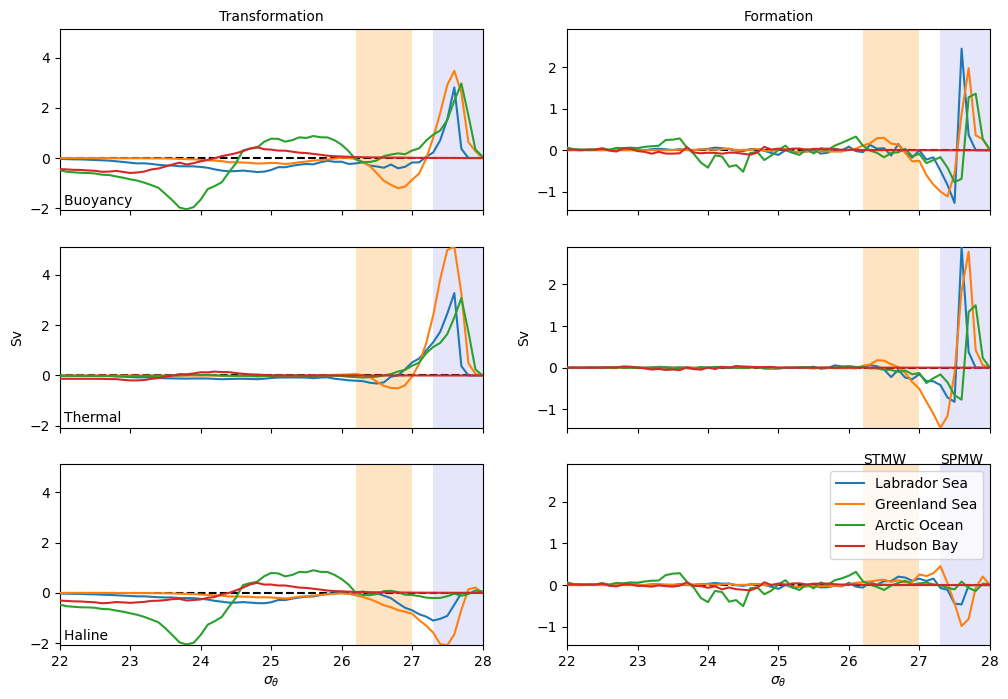

In [20]:
# High Latitude
fig, axs = make_plots(regions=[7, 8, 9, 10], hemisphere='nh', xlim=[22, 28], plot_total=False)

#### Tropical evaporative basins

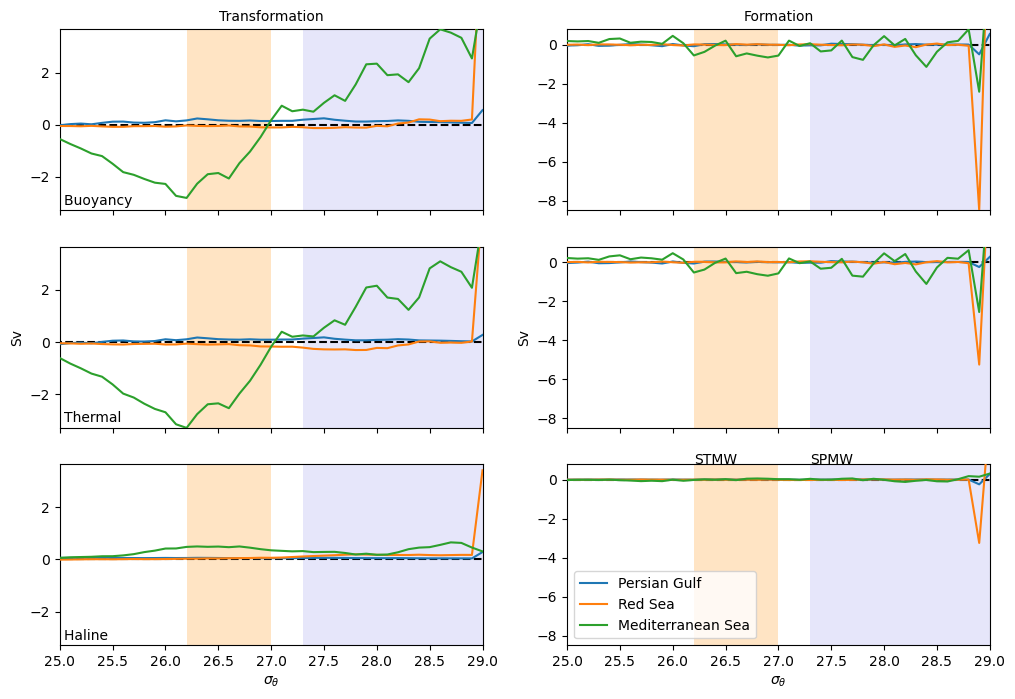

In [21]:
# Tropical evaporative basins
fig, axs = make_plots(regions=[3, 4, 6], hemisphere='nh', xlim=[25, 29], plot_total=False)

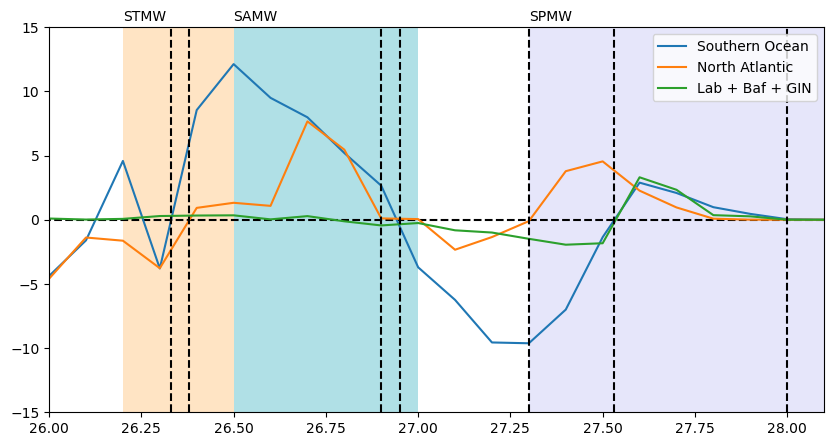

In [93]:
# Make figure layout
fig, ax = plt.subplots(figsize=(10, 5))
ylim = [-15, 15]
ax.plot([19, 29], [0, 0], 'k--')
ax.plot(sigma_index, wmtrfr['sh']['fr']['total'][0, :], '-', label='Southern Ocean')
ax.plot(sigma_index, wmtrfr['nh']['fr']['total'][5, :], '-', label='North Atlantic')
ax.plot(sigma_index, wmtrfr['nh']['fr']['total'][(7, 8), :].sum(axis=0), '-', label='Lab + Baf + GIN')

for wm in watermasses:
    sigmas = [(sigma, sigma) for sigma in watermasses[wm]['sigma']]
    ax.fill_betweenx(ylim, *sigmas, fc=watermasses[wm]['fc'], zorder=0)
    ax.text(sigmas[0][0], ylim[1]+0.5, wm, )

for sigma in [26.33, 26.38, 26.9, 26.95, 27.3, 27.53, 28]:
    ax.plot([sigma, sigma], ylim, 'k--')
ax.set_xlim([26, 28.1])
ax.set_ylim(ylim)

ax.legend()